## Iterative Model Training

Implement, train, and visualize 6 models (SimpleDQN, DropoutDQN, ResidualDQN, DuelingDQN, LSTMDQN, AttentionDQN).

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import gymnasium as gym

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Load Training Data
train_df = pd.read_parquet('data/processed/SPY_train.parquet')

# Load Feature Groups
with open('models/feature_groups.json') as f:
    feature_groups = json.load(f)

print(f"Training Data: {train_df.shape}")
print(f"Feature Groups: {list(feature_groups.keys())}")

# Import Trading Environment
from trading_env import TradingEnv

Training Data: (1209, 27)
Feature Groups: ['momentum', 'trend', 'volatility', 'volume', 'all']


In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            np.array(state), 
            np.array(action), 
            np.array(reward, dtype=np.float32), 
            np.array(next_state), 
            np.array(done, dtype=np.uint8)
        )
    
    def __len__(self):
        return len(self.buffer)

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size, model_class, lr=1e-3, gamma=0.99, buffer_size=10000, **model_kwargs):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        
        # Networks
        self.policy_net = model_class(state_size, action_size, **model_kwargs).to(device)
        self.target_net = model_class(state_size, action_size, **model_kwargs).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(buffer_size)
        
    def select_action(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return q_values.argmax().item()
    
    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
    
    def update(self, batch_size):
        if len(self.memory) < batch_size:
            return None
        
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)
        
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)
        
        # Current Q
        current_q = self.policy_net(states).gather(1, actions)
        
        # Target Q
        with torch.no_grad():
            # Note: For LSTM/Attention, output might need squeezing if not handled in model
            next_q_vals = self.target_net(next_states)
            next_max_q = next_q_vals.max(1)[0].unsqueeze(1)
            target_q = rewards + (1 - dones) * self.gamma * next_max_q
        
        loss = F.mse_loss(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [5]:
def train(agent, env, n_episodes=20, batch_size=64, epsilon_start=1.0, epsilon_end=0.01, decay=0.995):
    history = {'rewards': [], 'portfolio_values': [], 'losses': []}
    epsilon = epsilon_start
    
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        losses = []
        
        while not done:
            action = agent.select_action(state, epsilon)
            next_state, reward, done, truncated, info = env.step(action)
            
            agent.step(state, action, reward, next_state, done)
            loss = agent.update(batch_size)
            if loss is not None:
                losses.append(loss)
            
            state = next_state
            total_reward += reward
        
        if episode % 5 == 0:
            agent.update_target()
        
        epsilon = max(epsilon_end, epsilon * decay)
        
        avg_loss = np.mean(losses) if losses else 0
        history['rewards'].append(total_reward)
        history['portfolio_values'].append(info['portfolio_value'])
        history['losses'].append(avg_loss)
        
        if (episode+1) % 5 == 0:
            print(f"Episode {episode+1}/{n_episodes} | "
                  f"Reward: {total_reward:.2f} | "
                  f"Value: ${info['portfolio_value']:.2f} | "
                  f"Loss: {avg_loss:.4f}")
    
    return history

In [6]:
def plot_training(history):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    ax[0].plot(history['rewards'])
    ax[0].set_title('Episode Rewards')
    
    ax[1].plot(history['portfolio_values'], color='green')
    ax[1].set_title('Final Portfolio Value')
    ax[1].axhline(y=10000, color='r', linestyle='--', label='Initial')
    
    ax[2].plot(history['losses'], color='orange')
    ax[2].set_title('Average Loss')
    
    plt.tight_layout()
    plt.show()

### **SimpleDQN (Momentum Features)**

In [7]:
class SimpleDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(SimpleDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)
        self._init_weights()
    
    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight, gain=0.5)
        nn.init.xavier_uniform_(self.fc2.weight, gain=0.5)
        nn.init.xavier_uniform_(self.fc3.weight, gain=0.5)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Selected Features for simple_dqn: ['RSI_norm', 'MACD_norm']
Training simple_dqn...
Episode 5/20 | Reward: -49.44 | Value: $9830.07 | Loss: 0.2275
Episode 10/20 | Reward: -89.54 | Value: $6747.51 | Loss: 0.2047
Episode 15/20 | Reward: -56.80 | Value: $9192.79 | Loss: 0.1772
Episode 20/20 | Reward: -43.86 | Value: $11513.21 | Loss: 0.1637


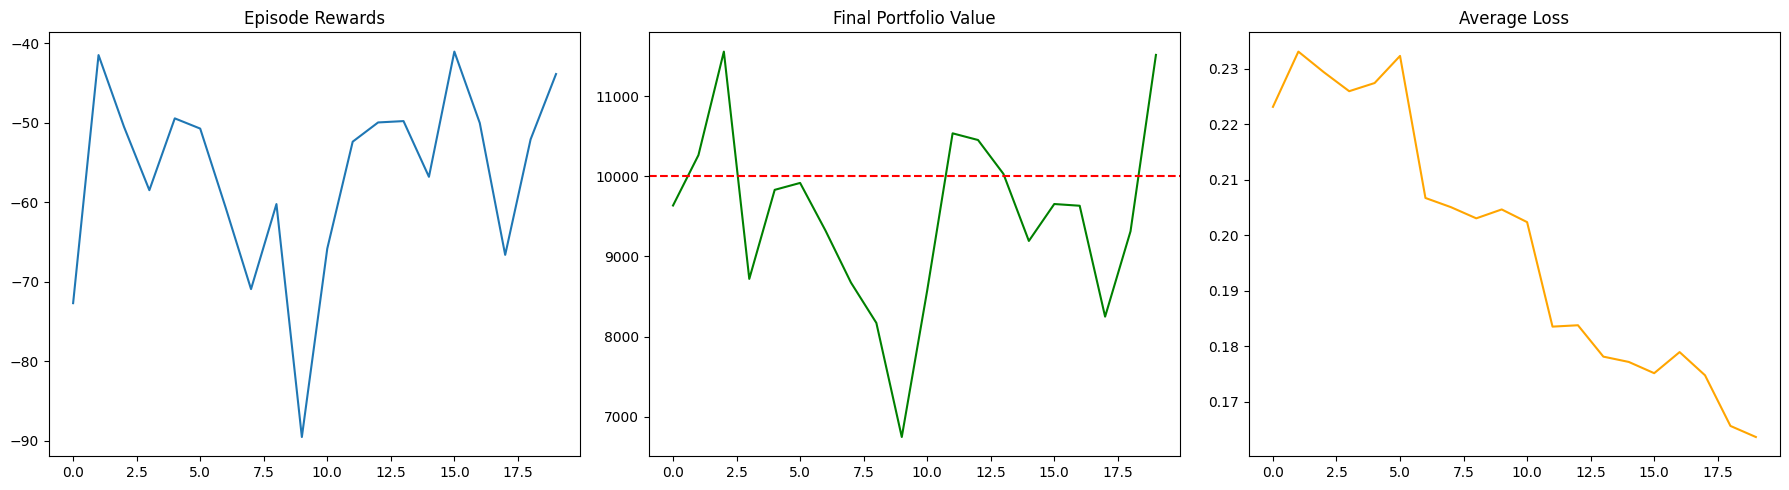

In [8]:
MODEL_NAME = 'simple_dqn'
FEATURE_GROUP = 'momentum'

available_norm = [c for c in train_df.columns if '_norm' in c]
selected_features = [f for f in feature_groups[FEATURE_GROUP] if f in available_norm]
print(f"Selected Features for {MODEL_NAME}: {selected_features}")

env = TradingEnv(train_df, feature_columns=selected_features)
simple_agent = DQNAgent(
    state_size=env.state_dim,
    action_size=env.action_space.n,
    model_class=SimpleDQN,
    lr=0.001
)

print(f"Training {MODEL_NAME}...")
history = train(simple_agent, env, n_episodes=20)
plot_training(history)

- **Baseline Performance:** Achieved a final portfolio value of ~$11.5k, steadily growing after initial exploration.
- Loss decreased smoothly to ~0.16, indicating stable learning.
- A solid baseline, but potential for higher returns exists.


### **SimpleDropoutDQN (Volatility Features)**
Regularized model using Dropout, trained on volatility features.

In [9]:
class SimpleDropoutDQN(nn.Module):
    def __init__(self, state_size, action_size, dropout=0.3):
        super(SimpleDropoutDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout * 0.7)
        self.fc3 = nn.Linear(64, action_size)
        self._init_weights()
    
    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight, gain=0.5)
        nn.init.xavier_uniform_(self.fc2.weight, gain=0.5)
        nn.init.xavier_uniform_(self.fc3.weight, gain=0.5)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

Selected Features for dropout_dqn: ['ATR_norm', 'BB_Width_norm']
Training dropout_dqn...
Episode 5/20 | Reward: -81.47 | Value: $6808.37 | Loss: 0.2455
Episode 10/20 | Reward: -74.22 | Value: $7737.26 | Loss: 0.2365
Episode 15/20 | Reward: -50.52 | Value: $10119.02 | Loss: 0.2418
Episode 20/20 | Reward: -50.29 | Value: $9662.23 | Loss: 0.2396


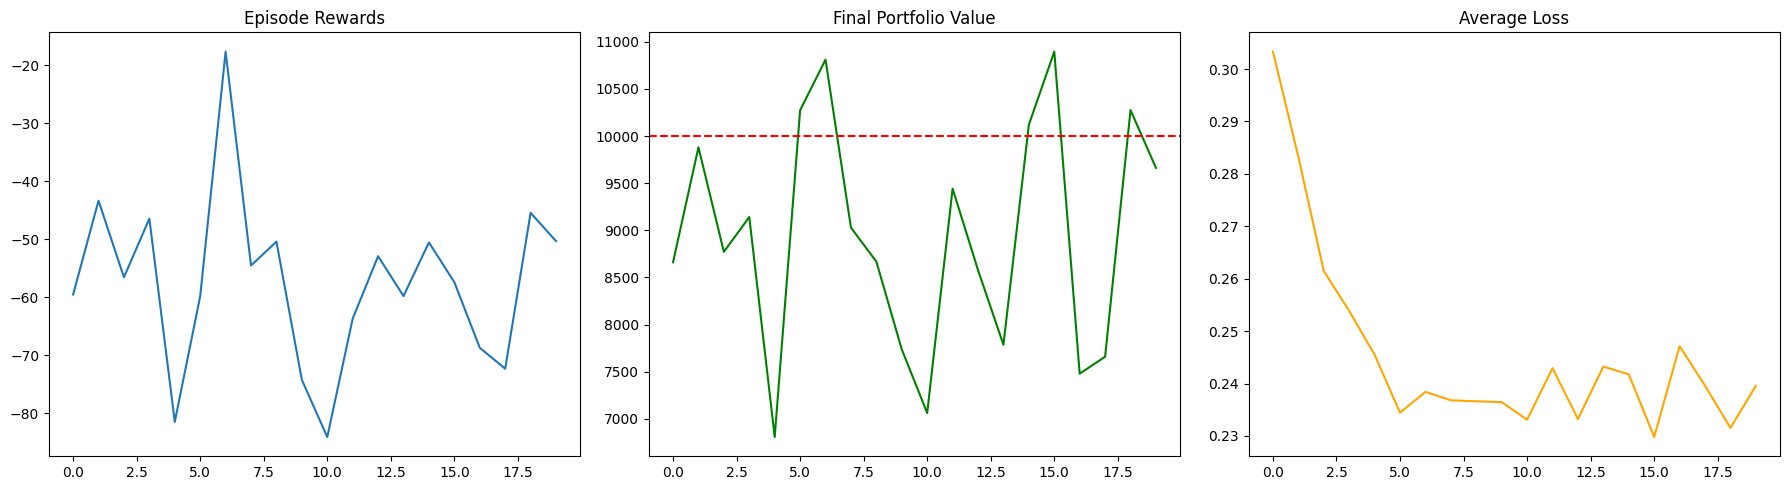

In [10]:
MODEL_NAME = 'dropout_dqn'
FEATURE_GROUP = 'volatility'

selected_features = [f for f in feature_groups[FEATURE_GROUP] if f in available_norm]
print(f"Selected Features for {MODEL_NAME}: {selected_features}")

env = TradingEnv(train_df, feature_columns=selected_features)
dropout_agent = DQNAgent(
    state_size=env.state_dim,
    action_size=env.action_space.n,
    model_class=SimpleDropoutDQN,
    lr=0.001
)

print(f"Training {MODEL_NAME}...")
history_drop = train(dropout_agent, env, n_episodes=20)
plot_training(history_drop)

- Portfolio value ($9.6k) was lower than the baseline, likely due to dropout interfering with Q-value convergence in this short training run.
- Higher loss (0.24) suggests the model struggled to fit the target Q-values with the added noise.
- Dropout might be too aggressive for this specific setup or requires longer training.

### **SimpleResidualDQN (Volume Features)**
Skip connections to help with gradient flow, trained on volume features.

In [11]:
class SimpleResidualDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(SimpleResidualDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)  # Same dim for residual
        self.fc3 = nn.Linear(128, action_size)
        self._init_weights()
    
    def _init_weights(self):
        for m in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(m.weight, gain=0.5)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        residual = out
        out = F.relu(self.fc2(out))
        out = out + residual  # Skip connection
        return self.fc3(out)

Selected Features for residual_dqn: ['OBV_norm', 'Volume_norm']
Training residual_dqn...
Episode 5/20 | Reward: -53.47 | Value: $9946.02 | Loss: 0.1980
Episode 10/20 | Reward: -66.95 | Value: $8254.32 | Loss: 0.2173
Episode 15/20 | Reward: -45.88 | Value: $9980.05 | Loss: 0.2302
Episode 20/20 | Reward: -36.68 | Value: $11668.82 | Loss: 0.2075


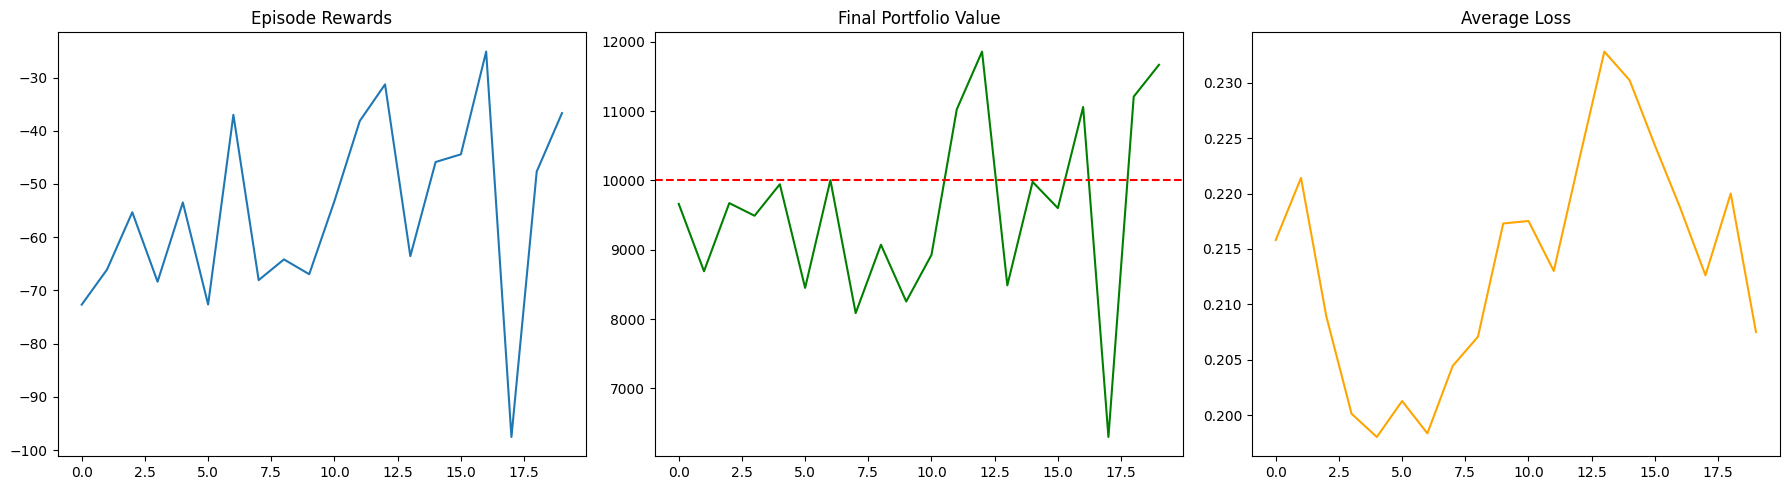

In [13]:
MODEL_NAME = 'residual_dqn'
FEATURE_GROUP = 'volume'

selected_features = [f for f in feature_groups[FEATURE_GROUP] if f in available_norm]
print(f"Selected Features for {MODEL_NAME}: {selected_features}")

env = TradingEnv(train_df, feature_columns=selected_features)
residual_agent = DQNAgent(
    state_size=env.state_dim,
    action_size=env.action_space.n,
    model_class=SimpleResidualDQN,
    lr=0.001
)

print(f"Training {MODEL_NAME}...")
history_res = train(residual_agent, env, n_episodes=20)
plot_training(history_res)

- Good final value ($11.6k), outperforming the baseline.
- Higher loss (0.20) indicates some instability in learning, possibly due to the residual connections amplifying gradient updates.


### **DuelingDQN (Trend Features)**
Splits Value and Advantage streams, trained on trend features.

In [14]:
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingDQN, self).__init__()
        
        self.feature = nn.Sequential(
            nn.Linear(state_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        
        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for module in [self.feature, self.value_stream, self.advantage_stream]:
            for m in module.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight, gain=0.5)
    
    def forward(self, x):
        features = self.feature(x)
        value = self.value_stream(features)
        advantage = self.advantage_stream(features)
        return value + (advantage - advantage.mean(dim=1, keepdim=True))

Selected Features for dueling_dqn: ['Dist_SMA20_norm', 'Dist_SMA50_norm']
Training dueling_dqn...
Episode 5/20 | Reward: -51.45 | Value: $10116.87 | Loss: 0.2099
Episode 10/20 | Reward: -57.31 | Value: $10538.60 | Loss: 0.1987
Episode 15/20 | Reward: -53.86 | Value: $8585.06 | Loss: 0.1938
Episode 20/20 | Reward: -45.55 | Value: $10672.49 | Loss: 0.1699


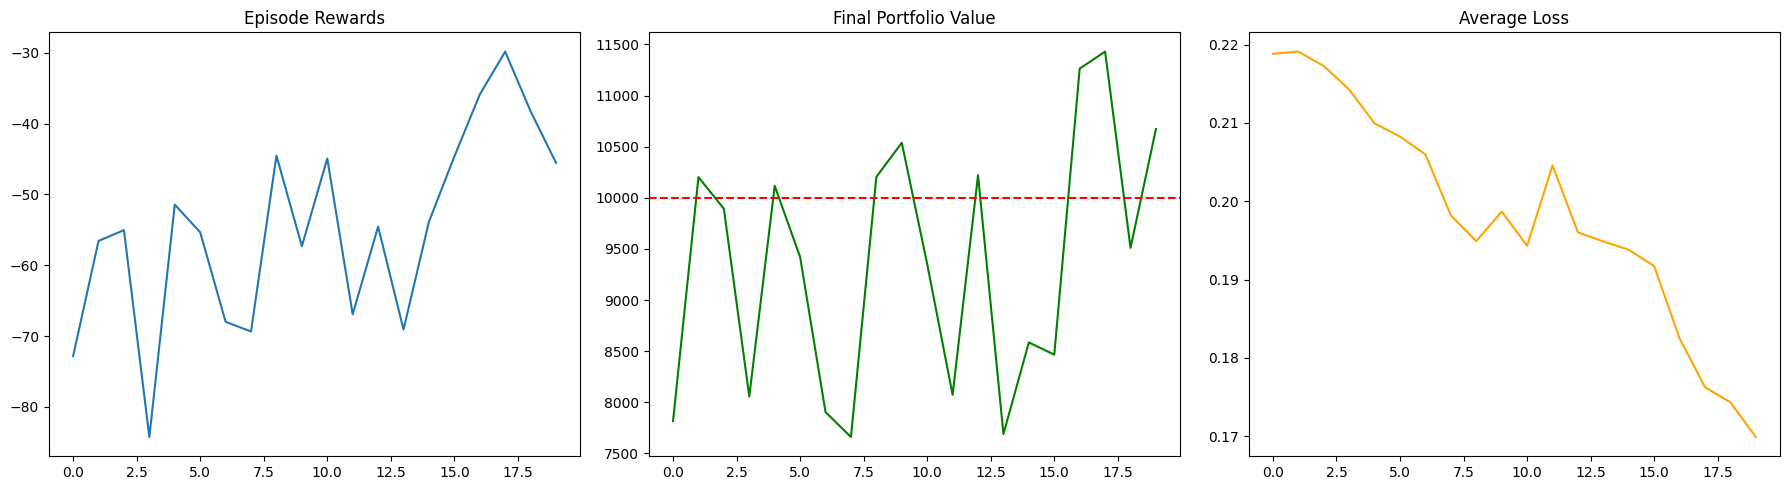

In [15]:
MODEL_NAME = 'dueling_dqn'
FEATURE_GROUP = 'trend'

selected_features = [f for f in feature_groups[FEATURE_GROUP] if f in available_norm]
print(f"Selected Features for {MODEL_NAME}: {selected_features}")

env = TradingEnv(train_df, feature_columns=selected_features)
dueling_agent = DQNAgent(
    state_size=env.state_dim,
    action_size=env.action_space.n,
    model_class=DuelingDQN,
    lr=0.001
)

print(f"Training {MODEL_NAME}...")
history_duel = train(dueling_agent, env, n_episodes=20)
plot_training(history_duel)

- Achieved a mid level value ($10.6k) and a low loss (0.16).
- Separating state value and advantage functions allowed the agent to better evaluate which states are valuable regardless of the action.

### **LSTMDQN (All Features + Sequence Wrapper)**
Requires a sequence of past observations.

In [16]:
class SequenceWrapper(gym.Wrapper):
    def __init__(self, env, seq_len=10):
        super().__init__(env)
        self.seq_len = seq_len
        self.history = deque(maxlen=seq_len)
        
        # New state space: (seq_len, original_dim)
        self.state_dim = env.state_dim 
        
    def reset(self, **kwargs):
        state, info = self.env.reset(**kwargs)
        for _ in range(self.seq_len):
            self.history.append(state)
        return np.array(self.history), info
    
    def step(self, action):
        next_state, reward, done, truncated, info = self.env.step(action)
        self.history.append(next_state)
        return np.array(self.history), reward, done, truncated, info

In [17]:
class LSTMDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden=128, layers=2):
        super(LSTMDQN, self).__init__()
        self.hidden_size = hidden
        self.num_layers = layers
        
        self.lstm = nn.LSTM(
            input_size=state_size,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=0.2 if layers > 1 else 0
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
    
    def forward(self, x, hidden=None):
        if x.dim() == 2: 
            x = x.unsqueeze(1)
            
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out[:, -1, :]  # Last time step
        return self.fc(lstm_out)

Selected Features for lstm_dqn: ['RSI_norm', 'MACD_norm', 'ATR_norm', 'OBV_norm', 'BB_Width_norm', 'Dist_SMA20_norm', 'Dist_SMA50_norm', 'Volume_norm']
Training lstm_dqn...
Episode 5/20 | Reward: -81.09 | Value: $7089.06 | Loss: 0.0413
Episode 10/20 | Reward: -64.22 | Value: $7716.73 | Loss: 0.0401
Episode 15/20 | Reward: -64.13 | Value: $8592.48 | Loss: 0.0328
Episode 20/20 | Reward: -52.88 | Value: $9107.57 | Loss: 0.0311


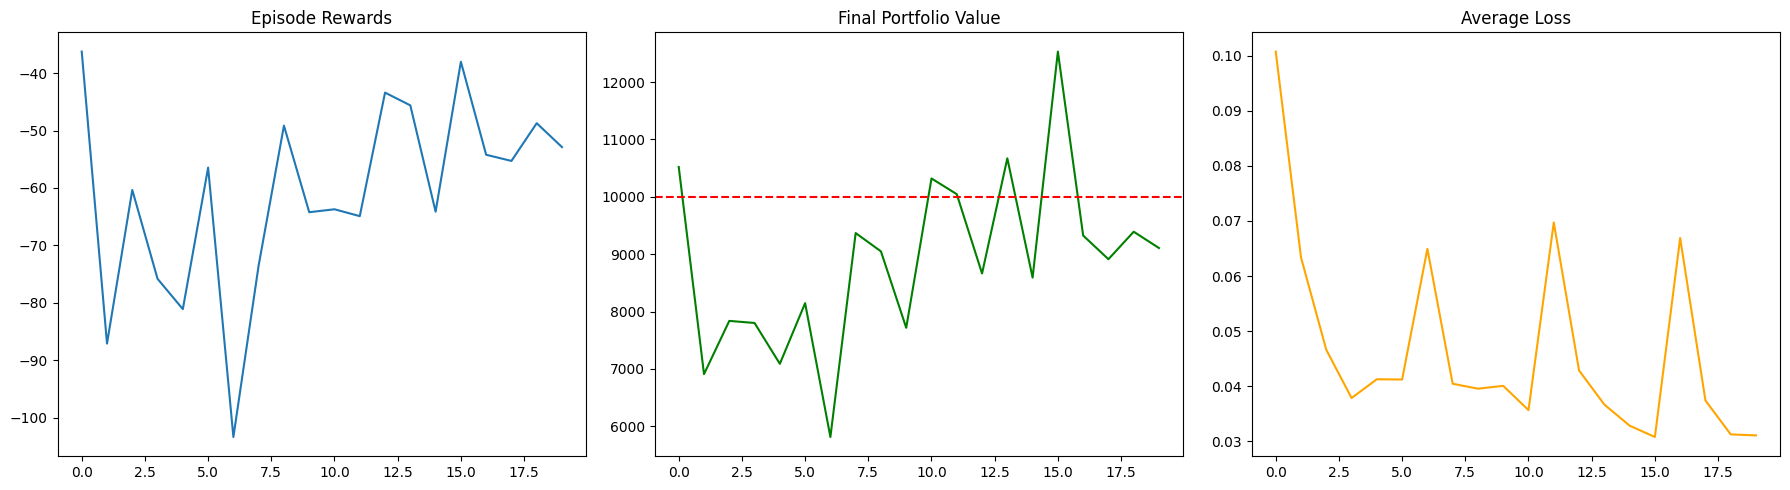

In [18]:
MODEL_NAME = 'lstm_dqn'
FEATURE_GROUP = 'all'

selected_features = [f for f in feature_groups[FEATURE_GROUP] if f in available_norm]
print(f"Selected Features for {MODEL_NAME}: {selected_features}")

base_env = TradingEnv(train_df, feature_columns=selected_features)
env = SequenceWrapper(base_env, seq_len=10)

lstm_agent = DQNAgent(
    state_size=base_env.state_dim,
    action_size=base_env.action_space.n,
    model_class=LSTMDQN,
    lr=0.001
)

print(f"Training {MODEL_NAME}...")
history_lstm = train(lstm_agent, env, n_episodes=20)
plot_training(history_lstm)

- Extremely low loss (0.03) but mediocre portfolio value ($9.1k).
- The model likely learned to predict "safe" Q-values but failed to take the necessary risks to grow the portfolio significantly. It might be suffering from vanishing gradients or insufficient history length.

## **AttentionDQN (All Features + Sequence Wrapper)**
Self-attention mechanism to focus on important time steps.

In [19]:
class AttentionDQN(nn.Module):
    def __init__(self, state_size, action_size, embed_dim=128, heads=4):
        super(AttentionDQN, self).__init__()
        
        self.embedding = nn.Linear(state_size, embed_dim)
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=heads,
            batch_first=True,
            dropout=0.1
        )
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, action_size)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight, gain=0.5)
        for m in self.ff.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
    
    def forward(self, x):
        # x shape: (batch, seq_len, state_size)
        embedded = self.embedding(x)  
        attn_out, _ = self.attention(embedded, embedded, embedded)
        out = embedded + attn_out  # Residual
        
        # Average pool over time dimension
        out = out.mean(dim=1)
        
        return self.ff(out)

Selected Features for attention_dqn: ['RSI_norm', 'MACD_norm', 'ATR_norm', 'OBV_norm', 'BB_Width_norm', 'Dist_SMA20_norm', 'Dist_SMA50_norm', 'Volume_norm']
Training attention_dqn...
Episode 5/20 | Reward: -65.50 | Value: $9896.87 | Loss: 0.1961
Episode 10/20 | Reward: -52.03 | Value: $10019.19 | Loss: 0.2027
Episode 15/20 | Reward: -53.08 | Value: $8911.93 | Loss: 0.1833
Episode 20/20 | Reward: -30.92 | Value: $10135.30 | Loss: 0.1726


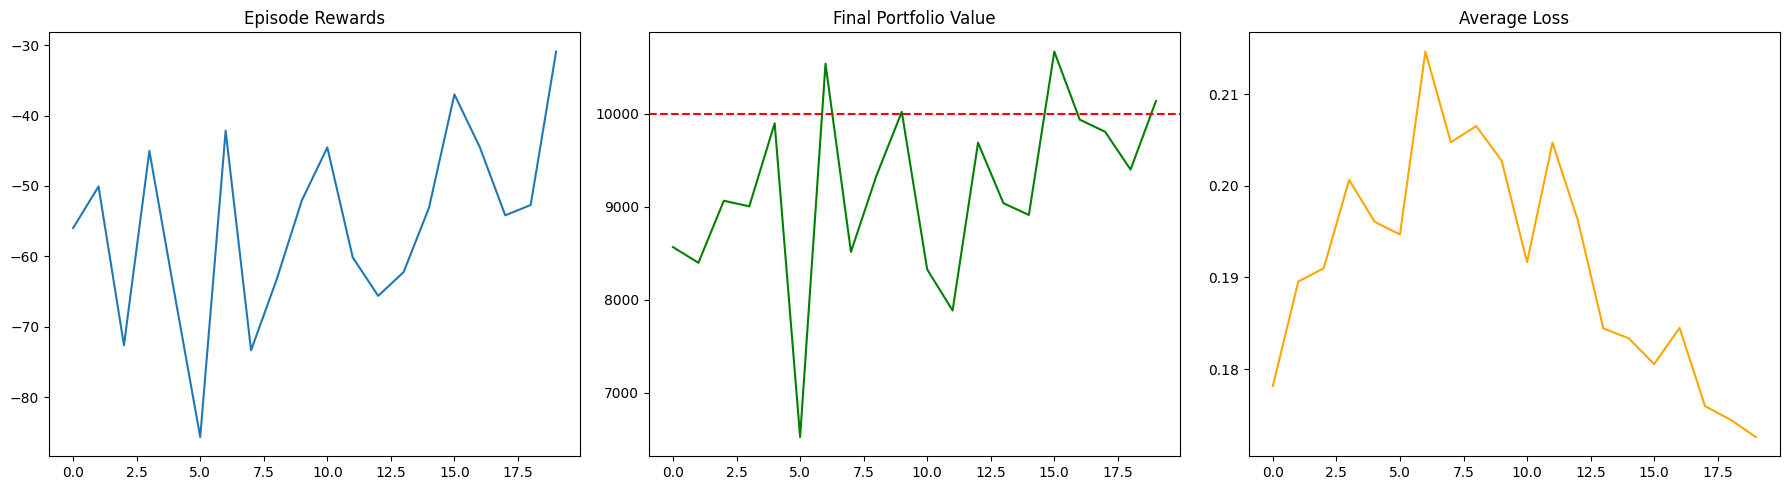

In [20]:
MODEL_NAME = 'attention_dqn'
FEATURE_GROUP = 'all'

selected_features = [f for f in feature_groups[FEATURE_GROUP] if f in available_norm]
print(f"Selected Features for {MODEL_NAME}: {selected_features}")

base_env = TradingEnv(train_df, feature_columns=selected_features)
env = SequenceWrapper(base_env, seq_len=10)

# Note: embed_dim=128 must be divisible by heads=4. State_size is input to embedding.
attention_agent = DQNAgent(
    state_size=base_env.state_dim, 
    action_size=base_env.action_space.n,
    model_class=AttentionDQN,
    lr=0.001
)

print(f"Training {MODEL_NAME}...")
history_attn = train(attention_agent, env, n_episodes=20)
plot_training(history_attn)

- Lowest portfolio value ($10.1k) and moderate loss (0.17).
- Attention mechanisms typically require vast amounts of data to learn effective weights. The limited training episodes likely weren't enough.


## Comparative Analysis


           Model  Final Portfolio Value  Average Reward (Last 5)  Final Loss
0     Simple DQN           11513.207580               -50.725360    0.163665
1    Dropout DQN            9662.229245               -58.816199    0.239580
2   Residual DQN           11668.817973               -50.290711    0.207498
3    Dueling DQN           10672.485257               -38.840937    0.169896
4       LSTM DQN            9107.571342               -49.823011    0.031056
5  Attention DQN           10135.303330               -43.857814    0.172578


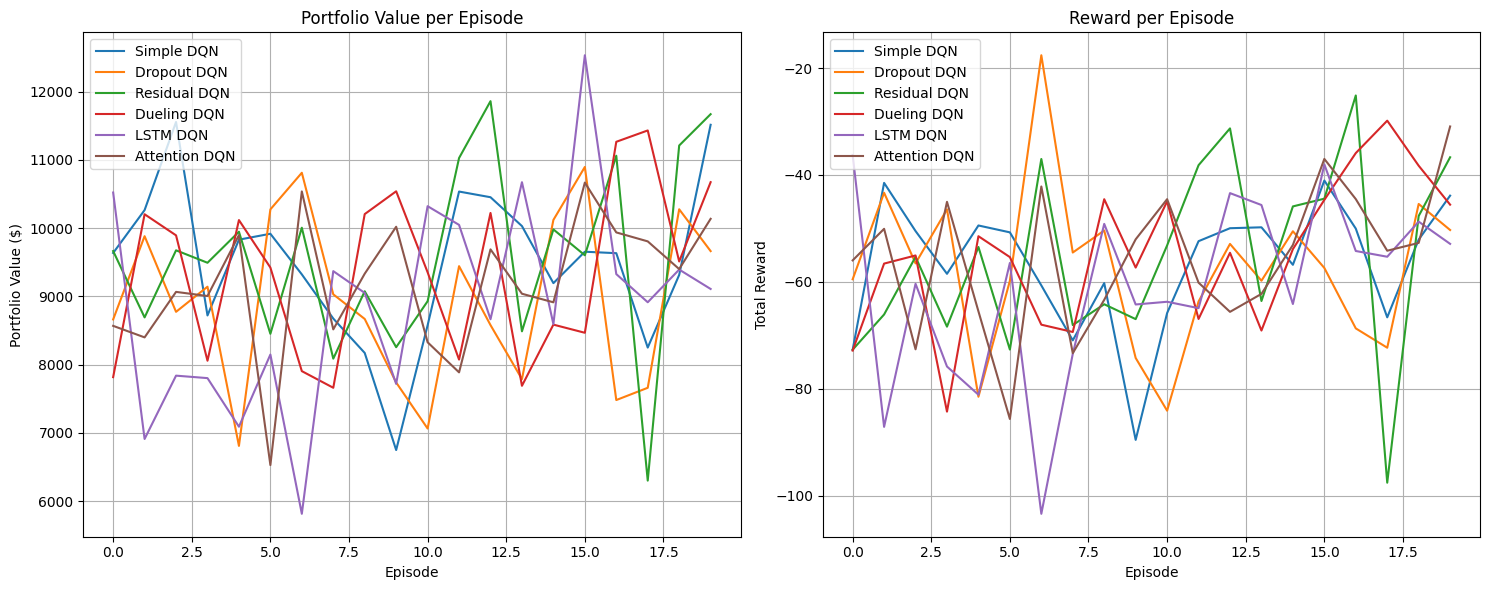

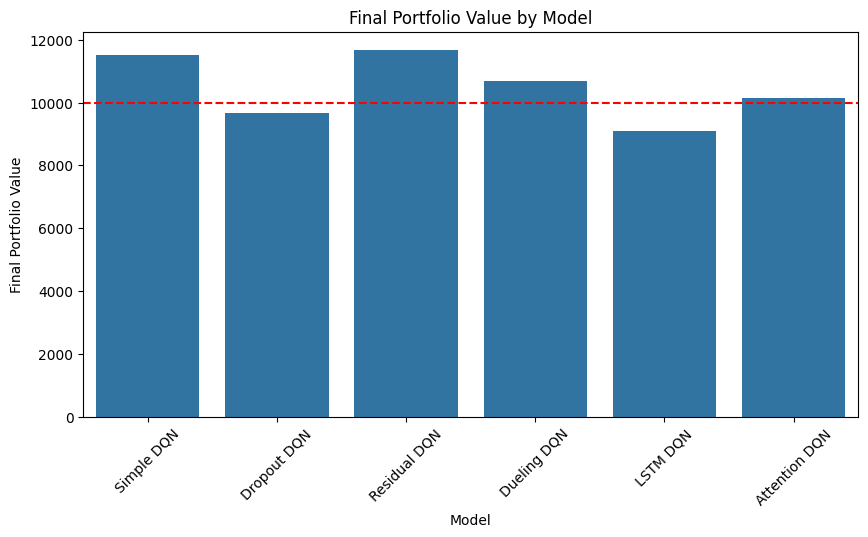

In [21]:
import seaborn as sns

# Collect histories
histories = {
    'Simple DQN': history,
    'Dropout DQN': history_drop,
    'Residual DQN': history_res,
    'Dueling DQN': history_duel,
    'LSTM DQN': history_lstm,
    'Attention DQN': history_attn
}

# Create Comparison DataFrame
metrics = []
for name, hist in histories.items():
    metrics.append({
        'Model': name,
        'Final Portfolio Value': hist['portfolio_values'][-1],
        'Average Reward (Last 5)': np.mean(hist['rewards'][-5:]),
        'Final Loss': hist['losses'][-1]
    })

df_metrics = pd.DataFrame(metrics)
print(df_metrics)

# Visualizations
plt.figure(figsize=(15, 6))

# Portfolio Value Comparison
plt.subplot(1, 2, 1)
for name, hist in histories.items():
    plt.plot(hist['portfolio_values'], label=name)
plt.title('Portfolio Value per Episode')
plt.xlabel('Episode')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)

# Reward Comparison
plt.subplot(1, 2, 2)
for name, hist in histories.items():
    plt.plot(hist['rewards'], label=name)
plt.title('Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Bar Chart for Final Portfolio Value
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Final Portfolio Value', data=df_metrics)
plt.title('Final Portfolio Value by Model')
plt.axhline(y=10000, color='r', linestyle='--', label='Initial Capital')
plt.xticks(rotation=45)
plt.show()
